In [1]:
import os
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

# Necessary dependencies

# qiskit
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit_ibm_provider import IBMProvider

# qutritium
from utility import *
from constant import *
from function import *

# numerical
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# data handlers
import pickle 

# plot
from matplotlib.ticker import MultipleLocator
plt.rcParams['axes.linewidth'] = 2.0
%config InlineBackend.figure_formats = ['svg']

# Backend specifications

Throughout these experiments we'll use the `ibm_brisbane` processor, focusing on `qubit = 109`.

In [3]:
provider = IBMProvider()
print(provider.backends())

backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 109
cbit = 0
num_qubits = int(qubit+1)
num_cbits = 1
weight = 1

[<IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>]


In [4]:
rough_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value*GHz
rough_12_freq = rough_01_freq + qubit_anharmonicty

print(r"f01 = "+f'{round(rough_01_freq/GHz, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/GHz, 4)}'+' GHz')

f01 = 4.985 GHz
f12 = 4.6778 GHz


# Appendix A. QuTiP simulation

Here I specify some matrices and vectors that will be useful for QuTip simulation

In [5]:
from qutip import *

gm1 = Qobj(np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 0]
]))

gm2 = Qobj(np.array([
    [0, -1j, 0],
    [1j, 0, 0],
    [0, 0, 0]
]))

gm3 = Qobj(np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, 0]
]))

gm6 = Qobj(np.array([
    [0, 0, 0],
    [0, 0, 1],
    [0, 1, 0]
]))

gm7 = Qobj(np.array([
    [0, 0, 0],
    [0, 0, -1j],
    [0, 1j, 0]
]))

gm9 = Qobj(np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, -1]
]))

ket0 = Qobj([[1], [0], [0]])
bra0 = ket0.dag()

ket1 = Qobj([[0], [1], [0]])
bra1 = ket1.dag()

ket2 = Qobj([[0], [0], [1]])
bra2 = ket2.dag()

---

# Phase 2: Finding Nemos. In this case Nemos are $(\alpha,\beta)$ 

## What we're trying to do?

At the end of phase 2, we want to accomplish one thing: **Relative phase advance of the qutrit systems.**

## How we're gonna approach it?

We'll use a technique called randomly parameterized circuit(s).

## Part 1. What randomly parameterized circuits are?

Ok. What randomly parameterized circuits (RPCs) are anyway? Before delving into that, we need to understand the way we generate random, arbitrary rotations in a qutrit circuit.

### Arbitrary rotations. From a mathematical standpoint

First, we need to understand the way we had been creating arbitrary rotation $SU(3)$ until recently. Since we can only access individual rotation in each subspace, throughout this note we consider only rotations that act (approximately) solely on the desired subspace. In other words, these are rotations that act non-trivially on

\begin{align}
\mathcal{H}^{(s)}
\end{align}

and act as an identity operator on 

\begin{align}
\mathcal{H}^{(rest)}
\end{align}

where the total Hilbert space of the qutrit being

\begin{align}
\mathcal{H} = \mathcal{H}^{(s)}\oplus\mathcal{H}^{(rest)}
\end{align}

## Part 2. I run the circuits

### Here's the new discriminator I've obtained

In [ ]:
with pulse.build(backend=backend) as cal_pi12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=64, amp=0.31419172290003516, sigma=16, beta=-0.4530201342281881), drive_chan)
    
cal_pi12_gate = qiskit.circuit.Gate('cal_pi12_sched', weight, [])

ground_circ = QuantumCircuit(num_qubits, num_cbits)
ground_circ.measure(qubit, cbit)

first_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
first_excited_state_circ.x(qubit)
first_excited_state_circ.measure(qubit, cbit)

second_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
second_excited_state_circ.x(qubit)
second_excited_state_circ.append(cal_pi12_gate, [qubit])
second_excited_state_circ.measure(qubit, cbit)
second_excited_state_circ.add_calibration(cal_pi12_gate, [qubit], cal_pi12_sched)

new_discrim = [ground_circ, first_excited_state_circ, second_excited_state_circ]

In [ ]:
calibrations = backend_defaults.instruction_schedule_map
calibrations.get('x', qubit), calibrations.get('sx', qubit)

In [ ]:
#define a pulse rotating theta around n-axis in subspace 0-1 and 1-2

def r01(theta, phi):
    with pulse.build(backend=backend) as r01_pulse:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(rough_01_freq, drive_chan)
        with pulse.phase_offset(-phi, drive_chan):
            pulse.play(pulse.Drag(duration=120,
                                      amp=0.18093652143360275*theta/np.pi,
                                      sigma=30,
                                      beta=-1.2643134385128565), drive_chan)

    return r01_pulse

def r12(theta, phi):
    with pulse.build(backend=backend) as r12_pulse:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(rough_12_freq, drive_chan)
        with pulse.phase_offset(-phi, drive_chan):
            pulse.play(pulse.Drag(duration=64,
                                      amp=0.31419172290003516*theta/np.pi,
                                      sigma=16,
                                      beta=-0.7678179824177247), drive_chan)

    return r12_pulse


def phase_tracking(order):
    exp_circs = []
    params = []
    for i in range(197):
        phi = np.random.default_rng().uniform(0, np.pi, len(order))
        theta = np.random.default_rng().uniform(0, np.pi, len(order))
        
        params.append(np.concatenate((theta, phi)))
        
        qc = QuantumCircuit(num_qubits, num_cbits)
        qc.append(X90_01, [qubit])
        qc.append(X90_12, [qubit])
        qc.add_calibration(X90_01, [qubit], r01(np.pi/2, 0))
        qc.add_calibration(X90_12, [qubit], r12(np.pi/2, 0))
        
        i = 0
        
        for level in order:
            if level == '1':
                name = r"$R^{01}$" + fr"$(\theta_{i+1}$" + ',' + fr'$\phi_{i+1})$'
                R01 = qiskit.circuit.Gate(name, weight, [])
                qc.append(R01, [qubit])
                qc.add_calibration(R01, [qubit], r01(theta[i], phi[i]))
            elif level == '2':
                name = r"$R^{12}$" + fr"$(\theta_{i+1}$" + ',' + fr'$\phi_{i+1})$'
                R12 = qiskit.circuit.Gate(name, weight, [])
                qc.append(R12, [qubit])
                qc.add_calibration(R12, [qubit], r12(theta[i], phi[i]))
            else:
                print('Out of level')
                break
            i = i + 1
        qc.measure(qubit, cbit)
        exp_circs.append(qc)
    exp_circs = new_discrim + exp_circs
    
    return exp_circs, params

Xpi01 = qiskit.circuit.Gate("$X_{\pi}^{01}$", 1, [])
Xpi12 = qiskit.circuit.Gate("$X_{\pi}^{12}$", 1, [])
X90_01 = qiskit.circuit.Gate(r'$X_{\pi/2}^{(01)}$', 1, [])
X90_12 = qiskit.circuit.Gate(r'$X_{\pi/2}^{(12)}$', 1, [])

In [ ]:
theta = np.random.default_rng().uniform(0, np.pi, len(order))

theta

In [10]:
order = "12211212112"

In [11]:
len(order)

11

In [12]:
exp_circs, params = phase_tracking(order)

In [13]:
np.shape(params)

(197, 22)

In [ ]:
np.savetxt('4feb_DRAG.csv', params, delimiter=',')

In [15]:
job = backend.run(exp_circs, meas_level=1, meas_return='single', shots=2048)
print(job.job_id())

cpzfjmad7we0008xt2v0


In [12]:
params_file = "./phase2/params/4feb_DRAG.csv"
params = np.genfromtxt(params_file, delimiter=',')
theta = params[:, :len(order)]
phi = params[:, len(order):]

In [13]:
job = provider.backend.retrieve_job('cpzfjmad7we0008xt2v0')
rpc11_data = DataAnalysis(experiment=job, average=False, shots=2048, qubit=0)
rpc11_data.retrieve_data(average=False)
rpc11_data.build_discrim()
rpc11_data.count_pop()
rpc11_data.error_mitiq()

In [14]:
def loss_func(param, theta, phi, p_exp, N_data=197):
    
    p_model = [population_model(theta[i], phi[i], *param, order) for i in range(N_data)]
    
    return mean_squared_error(p_model, population, squared = False)

In [15]:
population = rpc11_data.mitiq_data[3:]

In [16]:
def Z01(phi):
    return np.array([[np.exp(-1j * phi), 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])

def Z12(phi):
    return np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, np.exp(1j * phi)]])

def X01(theta):
    return np.array([[np.cos(theta / 2), -1j * np.sin(theta / 2), 0],
                     [-1j * np.sin(theta / 2), np.cos(theta / 2), 0],
                     [0, 0, 1]])


def X12(theta):
    return np.array([[1, 0, 0],
                     [0, np.cos(theta / 2), -1j * np.sin(theta / 2)],
                     [0, -1j * np.sin(theta / 2), np.cos(theta / 2)]])

def R01(theta, phi, phi2):
    R01_theory = np.array([[cos(theta/2), -1j*exp(-1j*phi)*sin(theta/2), 0],
                         [-1j*exp(1j*phi)*sin(theta/2), cos(theta/2), 0],
                         [0, 0, 1]])
    return Z12(phi2) @ R01_theory

def R12(theta, phi, phi0):
    R12_theory = np.array([[1, 0, 0],
                         [0, cos(theta/2), -1j*exp(-1j*phi)*sin(theta/2)],
                         [0, -1j*exp(1j*phi)*sin(theta/2), cos(theta/2)]])
    return Z01(phi0) @ R12_theory

def population_model(thetas, phis, phi2_01, phi0_12, order):
    ground = np.array([[1], [0], [0]])
    psi =  R12(np.pi/2, 0, phi0_12) @ R01(np.pi/2, 0, phi2_01) @ ground
    i = 0
    for level in order:
        if level == '1':
            psi =  R01(thetas[i], phis[i], phi2_01) @ psi
        else :
            psi = R12(thetas[i], phis[i], phi0_12) @ psi
        i = i + 1
    return [np.abs(psi[0][0])**2, np.abs(psi[1][0])**2, np.abs(psi[2][0])**2]

In [17]:
from scipy.optimize import minimize

N_seed = 10
N_data = 197
loss = 100
x_optimum = 0

for i in range(N_seed):
    x_initial = np.random.default_rng().uniform(-np.pi, np.pi, 2)
    res = minimize(loss_func, x0 = x_initial, args = (theta, phi, population))
    print(f"Iteration: {i}")
    if(res.fun < loss):
        loss = res.fun
        x_optimum = res.x%(2*pi)

print(x_optimum, loss)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
[2.6638051  1.05844905] 0.03621596784344319


In [62]:
x_optimum

array([2.67882364, 1.03481007, 6.24032381])

In [21]:
x_optimum

array([2.66357168, 1.05838761])

In [64]:
x_optimum_mod

array([2.67882364, 1.03481007, 6.24032381])

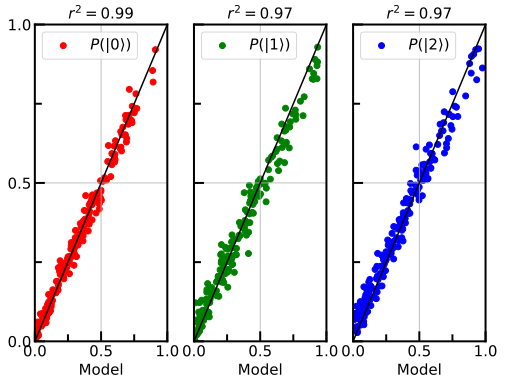

In [47]:
fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(7,5), dpi=300)

fig.tight_layout()

for ax in axs:
    ax.tick_params(axis='both', direction='in', which='both', labelsize=15)
    ax.tick_params(axis='both', which='major', length=10, width=2)
    ax.tick_params(axis='both', which='minor', length=7, width=2)
    ax.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.grid()

colors = ['r', 'g', 'b']

for i in range(3):
    p_model = [p[i] for p in model_population]
    p_exp = [p[i] for p in population]
    axs[i].scatter(p_model, p_exp, color = colors[i], label=fr'$P(|{i}\rangle)$')
    xplt = np.linspace(0, 1, 1000)
    axs[i].plot(xplt, xplt, color = 'black')
    axs[i].axis(xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    axs[i].set_title(r'$r^2 = $' + str(np.round(r2_score(p_model, p_exp), 2)) , size=15)
    axs[i].set_xlabel('Model', size=15)
    axs[i].legend(fontsize=15)
    
fig.savefig('rpc.png', bbox_inches='tight', dpi=300)

In [40]:
population

array([[0.31807864, 0.16985633, 0.51206502],
       [0.43690559, 0.19496582, 0.36812859],
       [0.61630632, 0.1858542 , 0.19783948],
       [0.592754  , 0.24335353, 0.16389246],
       [0.41318143, 0.07271084, 0.51410773],
       [0.25161171, 0.62283789, 0.1255504 ],
       [0.69975467, 0.08665526, 0.21359008],
       [0.57351652, 0.03071853, 0.39576496],
       [0.08030446, 0.82713851, 0.09255703],
       [0.26673573, 0.12224532, 0.61101895],
       [0.3500832 , 0.56409552, 0.08582128],
       [0.61816274, 0.24262269, 0.13921457],
       [0.2219081 , 0.62806956, 0.15002234],
       [0.32228423, 0.29342691, 0.38428886],
       [0.16110735, 0.36347737, 0.47541528],
       [0.27756444, 0.43646653, 0.28596902],
       [0.74212594, 0.08303879, 0.17483526],
       [0.4520383 , 0.09245136, 0.45551034],
       [0.14807364, 0.56911057, 0.28281578],
       [0.46855624, 0.34439673, 0.18704703],
       [0.12805075, 0.49820535, 0.3737439 ],
       [0.03840175, 0.71812711, 0.24347114],
       [0.

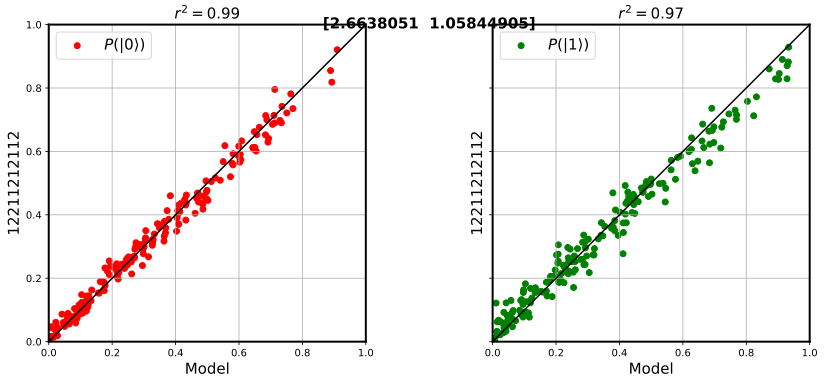

In [18]:
N_data = 197
param = np.array(x_optimum)
model_population = [population_model(theta[i], phi[i], *param, order) for i in range(N_data)]

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(13, 5), dpi=300)
plt.setp(axs.flat, aspect=1.0, adjustable='box')
fig.tight_layout()
plt.suptitle(str(x_optimum), weight = 'bold', size=15)
colors = ['r', 'g', 'b']

for i in range(2):
    p_model = [p[i] for p in model_population]
    p_exp = [p[i] for p in population]
    axs[i].scatter(p_model, p_exp, color = colors[i], label=fr'$P(|{i}\rangle)$')
    xplt = np.linspace(0, 1, 1000)
    axs[i].plot(xplt, xplt, color = 'black')
    axs[i].axis(xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    axs[i].set_title(r'$r^2 = $' + str(np.round(r2_score(p_model, p_exp), 2)) , size=15)
    axs[i].set_xlabel('Model', size=15)
    axs[i].set_ylabel(order, size=15)
    axs[i].grid()
    axs[i].legend(fontsize=15)

In [23]:
zero_data = rpc11_data.IQ_discrim[0]
one_data = rpc11_data.IQ_discrim[1]
two_data = rpc11_data.IQ_discrim[2]

In [ ]:
plt.figure(figsize=(8, 5))
plt.tick_params(axis='both', direction='in', which='both', width=1.5, labelsize=25)
plt.tick_params(axis='both', which='major', length=10, width=2)
plt.tick_params(axis='both', which='minor', length=7, width=2)
plt.minorticks_on()
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.xaxis.set_major_locator(MultipleLocator(40))
ax.yaxis.set_minor_locator(MultipleLocator(20))
ax.yaxis.set_major_locator(MultipleLocator(40))
plt.scatter(np.real(zero_data), np.imag(zero_data), s=2, color='red', label=r'Count $P_0$')
plt.scatter(np.real(np.mean(zero_data)), np.imag(np.mean(zero_data)), s=300, color='red', edgecolors='black', linewidth=3)
plt.scatter(np.real(one_data), np.imag(one_data), s=2, color='blue', label=r'Count $P_1$')
plt.scatter(np.real(np.mean(one_data)), np.imag(np.mean(one_data)), s=300, color='blue', edgecolors='black', linewidth=3)
plt.scatter(np.real(two_data), np.imag(two_data), s=2, color='green', label=r'Count $P_2$')
plt.scatter(np.real(np.mean(two_data)), np.imag(np.mean(two_data)), s=300, color='green', edgecolors='black', linewidth=3)
plt.xlim([-85, 85])
plt.ylim([-20, 85])
plt.savefig('discriminator012.png', dpi=300, bbox_inches='tight')